
================ FULL DATASET ================

Accuracy: 0.8853
AUC:      0.7478

================ 20% SMALL DATASET ================

Accuracy: 0.8830
AUC:      0.7296


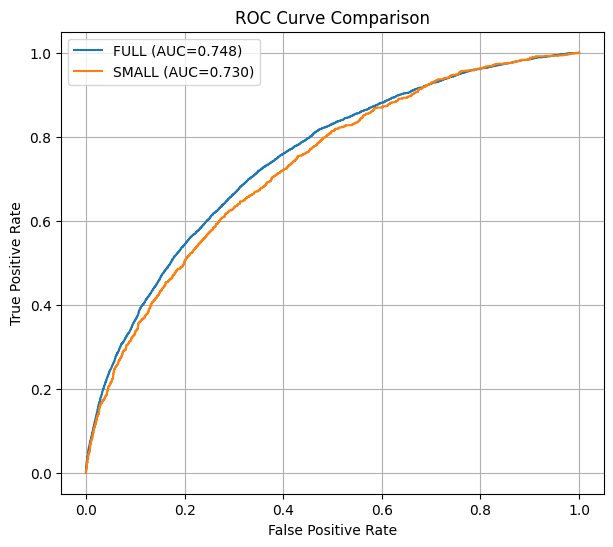

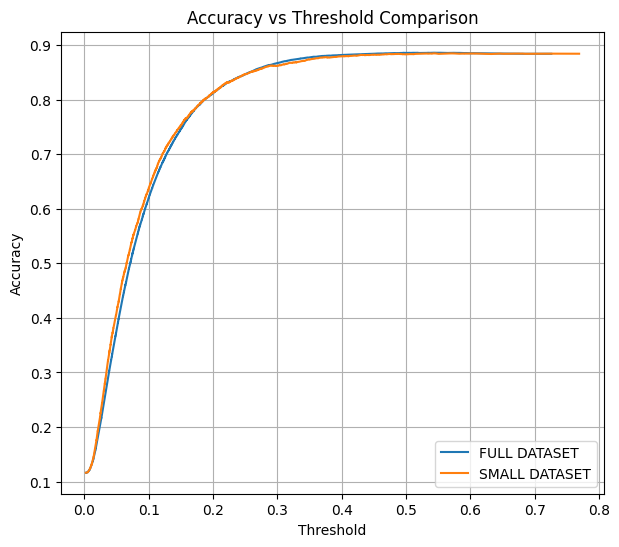


================ FINAL METRIC COMPARISON ================

FULL  DATASET  -> Accuracy: 0.8853 | AUC: 0.7478
SMALL DATASET  -> Accuracy: 0.8830 | AUC: 0.7296


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve
)
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Load Datasets
full = pd.read_csv("train_preprocessed.csv")
small = pd.read_csv("train_small.csv")

TARGET = "RiskFlag"
IDCOL = "ProfileID"

# Drop ID column if exists
if IDCOL in full.columns:
    full = full.drop(columns=[IDCOL])

if IDCOL in small.columns:
    small = small.drop(columns=[IDCOL])

def train_model(df, label="DATASET"):
    print(f"\n================ {label} ================\n")

    X = df.drop(columns=[TARGET])
    y = df[TARGET].astype(int)

    # Train-test split (80/20)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)

    # Simple Neural Network
    model = MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        solver='adam',
        max_iter=300,
        early_stopping=True,
        random_state=42
    )

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predictions
    probas = model.predict_proba(X_val_scaled)[:, 1]
    preds = (probas >= 0.5).astype(int)

    # Metrics
    accuracy  = accuracy_score(y_val, preds)
    auc       = roc_auc_score(y_val, probas)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC:      {auc:.4f}")

    # ROC curve points
    fpr, tpr, thresholds = roc_curve(y_val, probas)

    # Accuracy vs threshold
    accs = [accuracy_score(y_val, (probas >= t).astype(int)) for t in thresholds]

    return {
        "accuracy": accuracy,
        "auc": auc,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
        "accs": accs
    }


res_full  = train_model(full,  "FULL DATASET")
res_small = train_model(small, "20% SMALL DATASET")

# PLOT: ROC CURVE (FULL vs SMALL)

plt.figure(figsize=(7,6))
plt.plot(res_full["fpr"], res_full["tpr"], label=f"FULL (AUC={res_full['auc']:.3f})")
plt.plot(res_small["fpr"], res_small["tpr"], label=f"SMALL (AUC={res_small['auc']:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

# PLOT: ACCURACY vs THRESHOLD (FULL vs SMALL)

plt.figure(figsize=(7,6))
plt.plot(res_full["thresholds"],  res_full["accs"],  label="FULL DATASET")
plt.plot(res_small["thresholds"], res_small["accs"], label="SMALL DATASET")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold Comparison")
plt.legend()
plt.grid(True)
plt.show()

#Final Summary

print("\n================ FINAL METRIC COMPARISON ================\n")
print(f"FULL  DATASET  -> Accuracy: {res_full['accuracy']:.4f} | AUC: {res_full['auc']:.4f}")
print(f"SMALL DATASET  -> Accuracy: {res_small['accuracy']:.4f} | AUC: {res_small['auc']:.4f}")
